# Preparación de los datos

In [347]:
import os

import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))


In [348]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/anio2016.xls', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'Windows-1254',
 'confidence': 0.2255201122557638,
 'language': 'Turkish'}

In [349]:
# Se obtienen los datos de 2017
df_acoustics = pd.read_csv('data/raw/Anio2017.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


370

In [350]:
# Se les concatenan los datos del resto de años de los csv
for year in range(2018, 2024):
    path = 'data/raw/Anio' + str(year) + '.csv'
    df = pd.read_csv(path, encoding=result['encoding'], delimiter=';')
    df_acoustics = pd.concat([df_acoustics, df])

len(df_acoustics)


2292

In [351]:
# Se le concatenan, ahora, los datos del resto de años de los xls
month_dict = {'ene': '01',
                'feb': '02',
                'mar': '03',
                'abr': '04',
                'may': '05',
                'jun': '06',
                'jul': '07',
                'ago': '08',
                'sep': '09',
                'oct': '10',
                'nov': '11',
                'dic': '12'
                }

for year in range(2012, 2017):
    path = 'data/raw/Anio' + str(year) + '.xls'
    df = pd.read_excel('data/raw/Anio2016.xls', sheet_name=0, skiprows=4, usecols=range(1, 12))
    df['Fecha'] = 'ene-' + str(year)[2:]
    for sheet in range(1, 12):
        df_xls = pd.read_excel('data/raw/Anio2016.xls', sheet_name=sheet, skiprows=4, usecols=range(1, 12))
        df_xls['Fecha'] = list(month_dict.keys())[sheet] + '-' + str(year)[2:]
        df = pd.concat([df, df_xls])
    df_acoustics = pd.concat([df_acoustics, df])

len(df_acoustics)


4152

In [352]:
# Se fusionan las columnas "Nombre" y "Situación", que son la misma cosa
# Aunque pone que no hay nulos, es porque están marcados como "string". Se tratan más adelante
df_acoustics['Situación'] = df_acoustics['Situación'].fillna(df_acoustics['Nombre'])
df_acoustics = df_acoustics.drop(columns='Nombre')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4152 entries, 0 to 30
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4152 non-null   object
 1   NMT        4152 non-null   int64 
 2   Situación  4152 non-null   object
 3   Ld         4152 non-null   object
 4   Le         4152 non-null   object
 5   Ln         4152 non-null   object
 6   LAeq24     4152 non-null   object
 7   LAS01      4142 non-null   object
 8   LAS10      4142 non-null   object
 9   LAS50      4142 non-null   object
 10  LAS90      4142 non-null   object
 11  LAS99      4142 non-null   object
dtypes: int64(1), object(11)
memory usage: 421.7+ KB


In [354]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['Fecha'] = df_acoustics['Fecha'].str.split('-').apply(lambda x: f'{month_dict[x[0]]}-{x[1]}')
df_acoustics['Fecha'] = pd.to_datetime(df_acoustics['Fecha'], format='%m-%y')

df_acoustics = df_acoustics.rename(columns={'Fecha': 'mes'})

df_acoustics = df_acoustics.set_index('mes')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01',
               ...
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01'],
              dtype='datetime64[ns]', name='mes', length=4152, freq=None)

In [355]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics = df_acoustics.astype(str)

for col in df_acoustics.columns[2:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = df_acoustics[col].apply(lambda x: float(x) if x != 'N/D' else np.nan)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4152 entries, 2012-01-01 to 2023-02-01
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NMT        4152 non-null   object 
 1   Situación  4152 non-null   object 
 2   Ld         4100 non-null   float64
 3   Le         4100 non-null   float64
 4   Ln         4100 non-null   float64
 5   LAeq24     4099 non-null   float64
 6   LAS01      4078 non-null   float64
 7   LAS10      4078 non-null   float64
 8   LAS50      4078 non-null   float64
 9   LAS90      4078 non-null   float64
 10  LAS99      4078 non-null   float64
dtypes: float64(9), object(2)
memory usage: 389.2+ KB


In [356]:
# Se cambian los nombres de las columnas para mayor claridad
df_acoustics = df_acoustics.rename(columns={'NMT': 'num_medidas',
                                          'Situación': 'zonas',
                                            'Ld': 'sonido_mañana',
                                            'Le': 'sonido_tarde',
                                            'Ln': 'sonido_noche',
                                            'LAeq24': 'sonido_24_h',
                                            'LAS01': 'sonido_superado_1%',
                                            'LAS10': 'sonido_superado_10%',
                                            'LAS50': 'sonido_superado_50%',
                                            'LAS90': 'sonido_superado_90%',
                                            'LAS99': 'sonido_superado_99%'
                                            }
                                    )                   

df_acoustics.head()


,num_medidas,zonas,sonido_mañana,sonido_tarde,sonido_noche,sonido_24_h,sonido_superado_1%,sonido_superado_10%,sonido_superado_50%,sonido_superado_90%,sonido_superado_99%
mes,,,,,,,,,,,
2012-01-01,86,Tres Olivos,59.2,58.2,56.5,58.3,67.2,61.4,52.1,39.0,36.5
2012-01-01,55,Urbanización Embajada II,57.1,55.1,58.8,57.5,63.4,58.1,50.4,43.9,41.6
2012-01-01,54,Ensanche de Vallecas,62.2,62.5,60.7,61.8,68.0,64.5,59.6,49.6,36.3
2012-01-01,50,Pza de Castilla,67.1,66.6,62.3,65.7,72.0,67.7,63.7,56.2,48.8
2012-01-01,48,Castellana,63.6,63.5,59.4,62.5,68.8,65.9,61.3,54.1,46.4


In [357]:
# Se pivota la tabla para que cada columna sea una zona y los valores sean el valor que supera los que hay el 50% del tiempo 
# Así podemos decir que la mayoría del tiempo se supera tal o cual valor
df_acoustics = df_acoustics.pivot_table(index='mes', columns='zonas', values='sonido_superado_50%')

df_acoustics.head()


zonas,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,58.0,59.6,58.7,52.3,59.8,57.2,67.9,44.1,61.3,61.4,...,63.9,58.1,63.7,66.5,55.8,65.7,52.1,50.4,53.9,52.6
2012-02-01,58.4,60.1,58.9,54.1,59.7,58.4,68.2,44.2,61.6,61.7,...,64.0,58.1,64.0,66.9,56.3,65.6,52.7,51.3,54.4,53.2
2012-03-01,57.5,58.9,57.9,53.4,59.0,57.1,67.6,44.0,60.8,60.6,...,63.4,58.0,63.1,65.7,54.4,64.8,51.8,50.6,53.0,52.8
2012-04-01,57.6,59.4,58.4,53.3,59.4,57.9,67.7,44.9,61.1,61.2,...,63.6,58.6,63.5,66.5,54.8,65.4,53.1,51.1,53.7,53.5
2012-05-01,56.9,58.2,57.8,52.5,58.9,57.5,67.3,44.5,60.2,60.5,...,63.1,58.3,63.0,65.9,53.4,64.6,52.2,50.3,53.2,54.0


In [358]:
# Plaza de España y Ramón y Cajal tienen muchos nulos
df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          133 non-null    float64
 1   Arturo Soria              127 non-null    float64
 2   Avda de Moratalaz         129 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  134 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                133 non-null    float64
 9   Cuatro Caminos            133 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  133 non-null    float64
 13  Ensanche de Vallecas      128 non-null    floa

In [359]:
# Se eliminan esas zonas
df_acoustics = df_acoustics.drop(columns=['Plaza de España', 'Ramón y Cajal'])


In [360]:
# Se establece la frecuencia "MS" ("month start") y se interpolan los nulos
df_acoustics = df_acoustics.asfreq('MS')

df_acoustics = df_acoustics.apply(lambda x: x.interpolate(method='linear'))

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          134 non-null    float64
 1   Arturo Soria              134 non-null    float64
 2   Avda de Moratalaz         134 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  134 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                134 non-null    float64
 9   Cuatro Caminos            134 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  134 non-null    float64
 13  Ensanche de Vallecas      134 non-nul

In [361]:
# Hay un valor de Gregorio Marañón que se resiste a ser imputado por ser el primero. Se le atribuye el más cercano
df_acoustics.loc[df_acoustics['Gregorio Marañón'].isna(), 'Gregorio Marañón'] = 67.8

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          134 non-null    float64
 1   Arturo Soria              134 non-null    float64
 2   Avda de Moratalaz         134 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  134 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                134 non-null    float64
 9   Cuatro Caminos            134 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  134 non-null    float64
 13  Ensanche de Vallecas      134 non-nul

In [362]:
df_acoustics.to_csv('data/processed/acoustics.csv')


# Análisis de estacionalidad

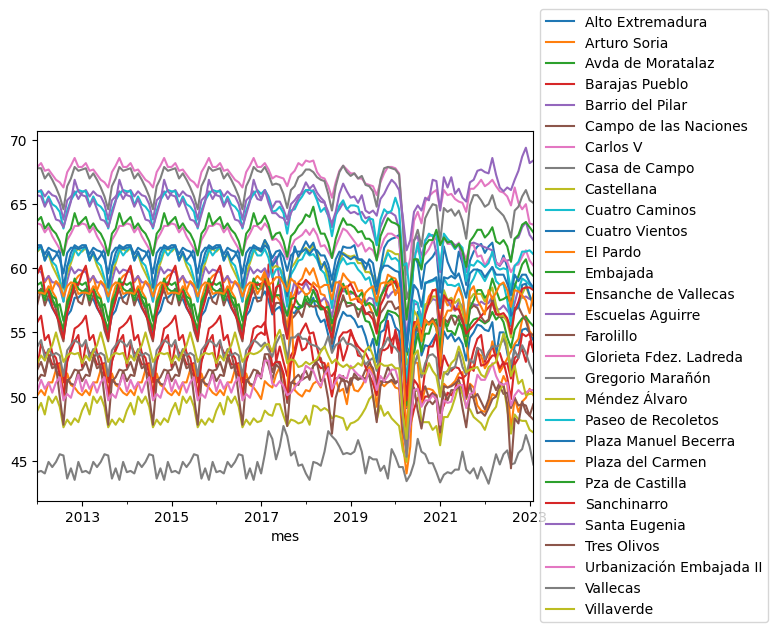

In [363]:
# Todas las zonas. Se percibe que la estacionalidad puede ser aditiva
df_acoustics.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


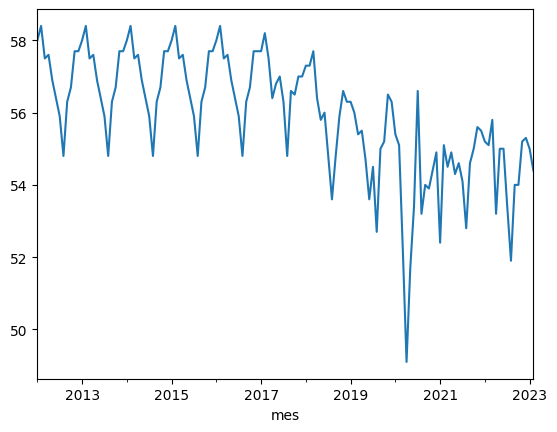

In [364]:
# Solo el primero
df_acoustics['Alto Extremadura'].plot()
plt.show()


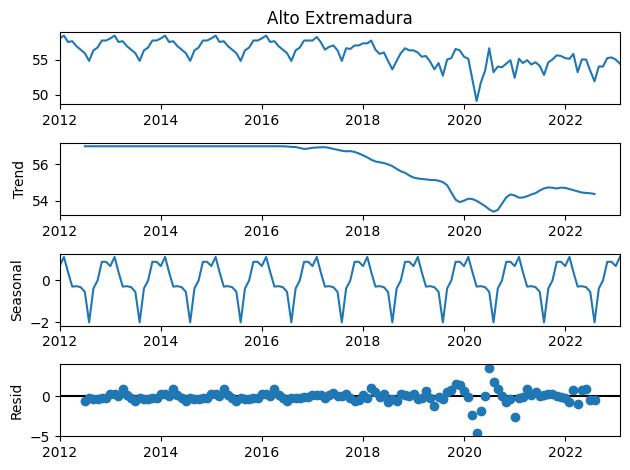

In [365]:
# Descomposición estacional del primero. La estacionalidad es clara
sm.tsa.seasonal_decompose(df_acoustics['Alto Extremadura'], model="additive", period=12).plot()
plt.show()


In [366]:
# Las zonas no son estacionarias
p_values = dict()
for zona in df_acoustics.columns:
    dickey_fuller = sts.adfuller(df_acoustics[zona])
    p_value = dickey_fuller[1]
    p_values[zona] = p_value
    if p_value > 0.05:
        print(f'La zona de {zona} no es estacionaria (p valor = {p_value})')


La zona de Alto Extremadura no es estacionaria (p valor = 0.922835251099431)
La zona de Arturo Soria no es estacionaria (p valor = 0.796932456537421)
La zona de Avda de Moratalaz no es estacionaria (p valor = 0.8700434736455145)
La zona de Barrio del Pilar no es estacionaria (p valor = 0.7636205486373678)
La zona de Campo de las Naciones no es estacionaria (p valor = 0.5868643487822909)
La zona de Carlos V no es estacionaria (p valor = 0.8562862491391741)
La zona de Casa de Campo no es estacionaria (p valor = 0.1239953408788334)
La zona de Castellana no es estacionaria (p valor = 0.8874866331589004)
La zona de Cuatro Caminos no es estacionaria (p valor = 0.790489745859664)
La zona de Cuatro Vientos no es estacionaria (p valor = 0.6788578468866838)
La zona de El Pardo no es estacionaria (p valor = 0.34357390762894313)
La zona de Embajada no es estacionaria (p valor = 0.244574176338355)
La zona de Ensanche de Vallecas no es estacionaria (p valor = 0.29894491145042223)
La zona de Escuelas

# Predicciones

## Holt-Winters

### Ejemplo con la primera zona 

In [367]:
size = int(len(df_acoustics)*0.8)
df_train_example = df_acoustics.iloc[:size].copy()
df_test_example = df_acoustics.iloc[size:].copy()


In [368]:
# Tendencia
ciclo, tendencia = sm.tsa.filters.hpfilter(df_train_example['Alto Extremadura'])
df_train_example['Alto Extremadura_tendencia'] = tendencia


In [369]:
# Medias móviles
df_train_example['Alto Extremadura_MM'] = df_train_example['Alto Extremadura'].rolling(5).mean()


In [370]:
# Medias móviles ponderadas, dan más importancia a los datos recientes
df_train_example['Alto Extremadura_MMP'] = df_train_example['Alto Extremadura'].ewm(alpha=0.2).mean()


In [371]:
# Suavizado simple
df_train_example['Alto Extremadura_EXPS'] = SimpleExpSmoothing(df_train_example['Alto Extremadura']).fit(smoothing_level=0.2).fittedvalues.shift(-1)


In [372]:
# Suavizado doble
df_train_example['Alto Extremadura_EXPS2'] = ExponentialSmoothing(df_train_example['Alto Extremadura']).fit(smoothing_level=0.2).fittedvalues.shift(-1)


In [373]:
# Suavizado triple
df_train_example['Alto Extremadura_EXPS3'] = ExponentialSmoothing(df_train_example['Alto Extremadura'], trend="add", seasonal="add", seasonal_periods=12).fit(smoothing_level=0.2).fittedvalues


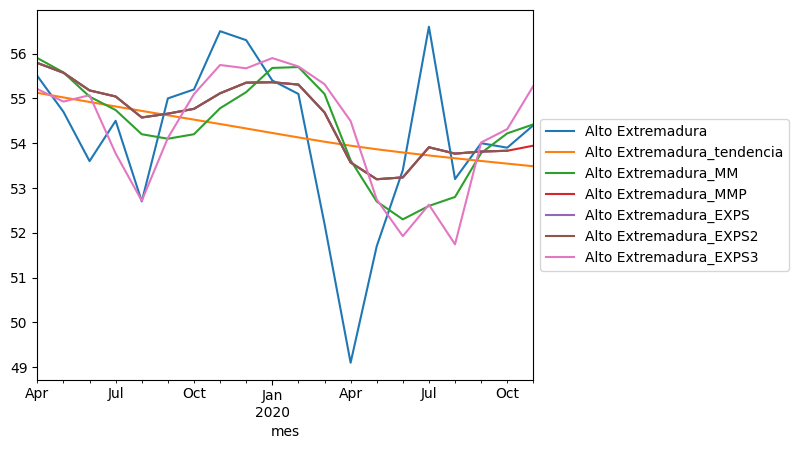

In [374]:
# Las medias móviles ponderadas, EXPS y EXPS2 coinciden
df_train_example[['Alto Extremadura', 
                    'Alto Extremadura_tendencia',
                    'Alto Extremadura_MM',
                    'Alto Extremadura_MMP',
                    'Alto Extremadura_EXPS',
                    'Alto Extremadura_EXPS2',
                    'Alto Extremadura_EXPS3'
                    ]
                ].tail(20).plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [375]:
test = df_test_example['Alto Extremadura']

test

mes
2020-12-01    54.9
2021-01-01    52.4
2021-02-01    55.1
2021-03-01    54.5
2021-04-01    54.9
2021-05-01    54.3
2021-06-01    54.6
2021-07-01    54.1
2021-08-01    52.8
2021-09-01    54.6
2021-10-01    55.0
2021-11-01    55.6
2021-12-01    55.5
2022-01-01    55.2
2022-02-01    55.1
2022-03-01    55.8
2022-04-01    53.2
2022-05-01    55.0
2022-06-01    55.0
2022-07-01    53.4
2022-08-01    51.9
2022-09-01    54.0
2022-10-01    54.0
2022-11-01    55.2
2022-12-01    55.3
2023-01-01    55.0
2023-02-01    54.4
Freq: MS, Name: Alto Extremadura, dtype: float64

In [376]:
# Predicción como ejemplo con suavizado triple
model = ExponentialSmoothing(df_train_example['Alto Extremadura'], trend="add", seasonal="add", seasonal_periods=12).fit()

test = df_test_example['Alto Extremadura']
pred = model.forecast(len(test))

pred


2020-12-01    54.337498
2021-01-01    54.412511
2021-02-01    54.623614
2021-03-01    53.701386
2021-04-01    53.156945
2021-05-01    52.945837
2021-06-01    52.779165
2021-07-01    52.745836
2021-08-01    51.256941
2021-09-01    52.768044
2021-10-01    53.112509
2021-11-01    54.001395
2021-12-01    53.938893
2022-01-01    54.013906
2022-02-01    54.225009
2022-03-01    53.302781
2022-04-01    52.758340
2022-05-01    52.547232
2022-06-01    52.380560
2022-07-01    52.347231
2022-08-01    50.858336
2022-09-01    52.369439
2022-10-01    52.713903
2022-11-01    53.602790
2022-12-01    53.540288
2023-01-01    53.615301
2023-02-01    53.826404
Freq: MS, dtype: float64

In [377]:
# Métricas de prueba
print(f'rmse: {mean_squared_error(test, pred, squared=False)}')
print(f'mse: {mean_squared_error(test, pred)}')
print(f'mae: {mean_absolute_error(test,pred)}')
print(f'r2: {r2_score(test, pred)}')
print(f'mape: {mean_absolute_percentage_error(test, pred)}')


rmse: 1.5566608327551807
mse: 2.423192948234053
mae: 1.4423307126076077
r2: -1.5930007034944418
mape: 0.02644120919749855


### Con todas las zonas

In [378]:
size = int(len(df_acoustics)*0.8)
df_train = df_acoustics.iloc[:size].copy()
df_test = df_acoustics.iloc[size:].copy()


In [379]:
# Ninguna prediccion Holt-Winters es buena. Hay que buscar un modelo que capture mejor la complejidad
r2_dict = dict()
for col in df_train.columns:
    test = df_test[col]
    r2_list = []
    for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        model_simple = SimpleExpSmoothing(df_train[col]).fit(smoothing_level=alpha)
        model_double = ExponentialSmoothing(df_train[col]).fit(smoothing_level=alpha)
        model_triple = ExponentialSmoothing(df_train[col], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.2)
        for model, model_name in [[model_simple, 'model_simple'], [model_double, 'model_double'], [model_triple, 'model_triple']]:
            pred = model.forecast(len(test))
            r2 = r2_score(test, pred)
            r2_list.append([r2, model_name, alpha])
    best = sorted(r2_list, reverse=True)[0]
    r2_dict[col] = best

r2_dict


{'Alto Extremadura': [-0.00587147344626171, 'model_simple', 1],
 'Arturo Soria': [-0.9008358178549714, 'model_simple', 0.2],
 'Avda de Moratalaz': [-0.0010779766893391773, 'model_simple', 0.4],
 'Barajas Pueblo': [-0.3861964749457596, 'model_simple', 0],
 'Barrio del Pilar': [-0.008431142252687929, 'model_simple', 0.4],
 'Campo de las Naciones': [-0.00016640229651687655, 'model_simple', 0.7],
 'Carlos V': [-0.0009056138520033841, 'model_simple', 0.6],
 'Casa de Campo': [-0.019327871593378232, 'model_simple', 1],
 'Castellana': [0.19454336152139595, 'model_triple', 1],
 'Cuatro Caminos': [-0.0005978725421593722, 'model_simple', 0.5],
 'Cuatro Vientos': [-0.0011434998469019853, 'model_simple', 0.2],
 'El Pardo': [0.16266725579317287, 'model_triple', 1],
 'Embajada': [-3.544823764056737e-05, 'model_double', 0],
 'Ensanche de Vallecas': [-0.010302246604132703, 'model_simple', 0.3],
 'Escuelas Aguirre': [-0.024872200050536586, 'model_simple', 0.2],
 'Farolillo': [-0.060725967288364435, 'mod

## ARIMA

In [ ]:
# Se guardan los mejores hiperparámetros, el modelo y la r2 de cada zona en un diccionario
zone_dict = dict()
for col in df_train.columns:
    model = auto_arima(df_train[col], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
    best_order = model.order
    best_seasonal_order = model.seasonal_order
    pred = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1, n_periods=len(df_test))
    test = df_test[col]
    r2 = r2_score(test, pred)
    zone_dict[col] = {'params': best_order + best_seasonal_order,
                      'model': model,
                      'r2': r2
                      }


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=204.826, Time=1.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=237.672, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=238.400, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=235.425, Time=0.32 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=202.850, Time=0.87 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=205.260, Time=0.44 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=204.758, Time=2.12 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=203.856, Time=0.80 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=205.757, Time=3.80 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=219.116, Time=0.44 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=213.858, Time=0.52 sec
 ARIMA(3,1,2)(0,1,1)[12]             : AIC=204.505, Time=1.42 sec
 ARIMA(2,1,3)(0,1,1)[12]             : AIC=204.638, Time=1.37 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=237.302, Time=0.36 sec
 ARIMA(1,1,3)(0,1,1)[12]         

In [381]:
zone_dict


{'Alto Extremadura': {'params': (2, 1, 2, 0, 1, 1, 12),
  'model': ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
        suppress_warnings=True),
  'r2': -14.543871958309058},
 'Arturo Soria': {'params': (2, 1, 1, 0, 1, 1, 12),
  'model': ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
        suppress_warnings=True, with_intercept=False),
  'r2': -0.840698717915423},
 'Avda de Moratalaz': {'params': (2, 1, 1, 1, 0, 2, 12),
  'model': ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
        suppress_warnings=True, with_intercept=False),
  'r2': -1.2979970588292526},
 'Barajas Pueblo': {'params': (1, 0, 0, 1, 0, 0, 12),
  'model': ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
        suppress_warnings=True),
  'r2': 0.3336596907802799},
 'Barrio del Pilar': {'params': (0, 1, 3, 1, 1, 0, 12),
  'model': ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(1, 1, 0, 12),
        suppress_warnings=